In [1280]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from chiral_solve_complete import calculate_sigma_values

In [1281]:
wi = 700
wf = 2400 
wcount = 1700
wresolution = .01

ui = 1e-4
uf = 1-(1e-5)
ucount = 1000

mu = 0 #MeV, Chemical Potential
T = 18  #MeV, Temperature
mq = 9
mq_tolerance = 0.1
kappa = 1 #Constant

In [1282]:
#Blackness function. Returns f(u) and f'(u) as a list
def f(u,Q):
    f = 1-((1+(Q**2))*(u**4))+((Q**2)*(u**6))
    f_p = -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    return [f,f_p]
    
#Dilaton field.
def phi(u,zh,mug):
    phi = (mug**2)*(zh**2)*(u**2)
    phi_p = 2*u*(mug**2)*(zh**2)
    return [phi,phi_p]
    
#440 MeV. The confinement scale
def mu_g():
    return 388 #440
    
#Related to black hole charge. Must return a value from 0 < Q^2 < 2
#Manually checked for mu = 0
def Q_func(zh):
    global q #Prevents function from interpretting q as a local variable
    
    # Initialize q variable to ensure it exists before use
    if not 'q' in globals():
        global q
        q = 0
    
    if mu == 0:
        q = 0
    else:
        if q == 0:
            q = (mu**3 + kappa * np.pi * T * mu * (kappa * np.pi * T + np.sqrt((kappa * np.pi * T)**2 + 2 * mu**2))) / (2 * kappa**3)
    return mu * zh / kappa

#Black Hole Horizon. calculated from T, mu, and k
#Manually checked for mu = 0
def z_h():
    if mu == 0:
        return 1 / (np.pi * T)
    
    return ((-T * np.pi * (kappa**2)) + ((kappa**2) * np.sqrt((T**2 * np.pi**2) + (2 * mu**2 / kappa**2)))) / mu**2   

#Values of lambda 1-4
def lam_function():
    return (7.438, -22.6/(6*(2**(1/2))), 4.2)

def calculate_variables():
    mug = mu_g()
    zh = z_h()
    Q = Q_func(zh)
    lambda1,lambda3,lambda4 = lam_function()
    g5 = 2*np.pi
    zeta = np.sqrt(3)/(2*np.pi)
    return (mug,zh,Q,lambda1,lambda3,lambda4,g5,zeta)

In [1283]:
#Coefficients
def d2():
    return 0

def d4(w,zh,mug,d_0,d_2):
    return (1/64)*(
        (32*d_2*(zh**2)*(mug**2))
        - (8*d_2*(zh**2)*(w**2))
        + (4*d_0*(zh**4)*(mug**2)*(w**2))
        - (3*d_0*(zh**4)*(w**4))
    )

def b2():
    return 1

def b4(w,g5,zh,mq,zeta,mug,b_2):
    b_4 = (b_2/8)*(
        (g5**2*mq**2*zh**2*zeta**2)
        +(4*zh**2*mug**2)
        -(zh**2*w**2)
    )
    return b_4

def b5(g5,mq,zh,zeta,b_2,d_2):
    b_5 = (2/15)*(
        b_2 * d_2 * (g5**2) * mq * zh * zeta
    )
    return b_5

def b6(w,g5,zh,zeta, mq,mug,Q,sigma,b_2,b_4,d_2):
    b_6 = (1/24)*(
        8*b_2
        + b_2*(d_2**2)*(g5**2)
        + 8*b_2*(Q**2)
        + b_4*(g5**2)*(mq**2)*(zh**2)*(zeta**2)
        + 8 * b_4*zh**2*mug**2
        + 2*b_2*(g5**2)*mq*(zh**4)*sigma
        - b_4*(zh**2)*(w**2)
    )
    return b_6

def b7(w,g5,zh,zeta,mq,mug,Q,sigma,b_2,b_4,b_5,d_2,d_4):
    b_7 = (1/(35*zeta))*(
        2*b_4*d_2*(g5**2)*mq*zh*(zeta**2)
        + 2*b_2*d_4*(g5**2)*mq*(zh**5)*(zeta**2)
        + b_5*(g5**2)*(mq**2)*(zh**2)*(zeta**3)
        + 10*b_5*(zh**2)*zeta*(mug**2)
        + 2*b_2*d_2*(g5**2)*(zh**3)*sigma
        - b_5*(zh**2)*zeta*(w**2)
    )
    return b_7

def h(w,g5,zh,zeta,mq,b_2,h_0):
    return (h_0*zh**2/(2*b_2))*((-w**2)+(g5**2*mq**2*zeta**2))

def h0():
    return 1

def h1():
    return 0

def h2():
    return 0

def h3(w,g5,zh,mug,zeta,mq,lambda3,h_0,h_1):
    return (
        (-2*h_0*g5**2*mq**3*zh**3*zeta**3*lambda3)
        +(h_1/3)*(
            (-w**2*zh**2)
            +(g5**2*mq**2*zh**2*zeta**2)
            +(2*zh**2*mug**2)
        )
    )

def h4(w,g5,mq,zh,mug,zeta,sigma,lambda3,b_2,b_4,h_h,h_0,h_1,h_2):
    return (
        (-3/4)*h_1*g5**2*mq**3*zh**3*zeta**3*lambda3
        + (h_2/8) * (
            -w**2*zh**2
            +g5**2*mq**2*zh**2*zeta**2
            +4*zh**2*mug**2
        )
        + (h_h/8) * (
            -6*b_4
            +2*b_2*zh**2*mug**2
        )
        + (h_0/8) * (
            9*g5**2*mq**4*zh**4*zeta**4*lambda3**2
            +2*g5**2*mq*zh**4*sigma
        )
    )

def h5(w,g5,zh,zeta,sigma,Q,lambda1,lambda3,lambda4,h_h,h_0,h_1,h_2,h_3,b_5):
    return (
        -(8*b_5*h_h/15)
        -(2/5)*h_2*g5**2*mq**3*zh**3*zeta**3*lambda3
        + (h_3/15)*(
            -w**2*zh**2
            +g5**2*mq**2*zh**2*zeta**2
            +6*zh**2*mug**2
        )
        +(h_1/15)*(
            4
            +4*Q**2
            +9*g5**2*mq**4*zh**4*zeta**4*lambda3**2
            +2*g5**2*mq*zh**4*sigma
        )
        +(h_0/15)*(
            18*g5**2*mq**5*zh**5*zeta**5*lambda3**3
            -24*g5**2*mq**5*zh**5*zeta**5*lambda3*lambda4
            -8*g5**2*mq**3*zh**5*zeta**3*lambda3*mug**2
            +2*g5**2*mq**3*zh**5*zeta**3*lambda1*lambda3*mug**2
            -2*g5**2*mq**2*zh**5*zeta*lambda3*sigma
        )
    )

def h6(w,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4,b_2,b_4,b_5,b_6,h_h,h_0,h_1,h_2,h_3,h_4):
    return (
        (-1/4)*h_3*g5**2*mq**3*zh**3*zeta**3*lambda3
        +(h_4/(24*zeta**2))*(
            -w**2*zh**2*zeta**2
            +g5**2*mq**2*zh**2*zeta**4
            +8*zh**2*zeta**2*mug**2
        )
        +(h_h/(24*zeta**2))*(
            4*b_2*zeta**2
            -10*b_5*zeta**2
            -10*b_6*zeta**2
            +4*b_2*Q**2*zeta**2
            +2*b_4*zh**2*zeta**2*mug**2
        )
        +(h_2/(24*zeta**2))*(
            8*zeta**2
            +8*Q**2*zeta**2
            +9*g5**2*mq**4*zh**4*zeta**6*lambda3**2
            +2*g5**2*mq*zh**4*zeta**2*sigma
        )
        +(h_1/(24*zeta**2))*(
            18*g5**2*mq**5*zh**5*zeta**7*lambda3**3
            -24*g5**2*mq**5*zh**5*zeta**7*lambda3*lambda4
            -8*g5**2*mq**3*zh**5*zeta**5*lambda3*mug**2
            +2*g5**2*mq**3*zh**5*zeta**5*lambda1*lambda3*mug**2
            -2*g5**2*mq**2*zh**5*zeta**3*lambda3*sigma
        )
        +(h_0/(24*zeta**2))*(
            -2*w**2*zh**2*zeta**2
            -2*Q**2*w**2*zh**2*zeta**2
            +g5**2*mq**2*zh**2*zeta**4
            +g5**2*mq**2*Q**2*zh**2*zeta**4
            -54*g5**2*mq**6*zh**6*zeta**8*lambda3**4
            +72*g5**2*mq**6*zh**6*zeta**8*lambda3**2*lambda4
            +24*g5**2*mq**4*zh**6*zeta**6*lambda3**2*mug**2
            -6*g5**2*mq**4*zh**6*zeta**6*lambda1*lambda3**2*mug**2
            -12*g5**2*mq**3*zh**6*zeta**4*lambda3**2*sigma
            +g5**2*zh**6*sigma**2
        )

    )

def h7(w,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4,b_7,h_h,h_0,h_1,h_2,h_3,h_4,h_5,h_6):
    return (
        -12*b_7*h_h/35
        -6*h_4*g5**2*mq**3*zh**3*zeta**3*lambda3
        + (h_5/(35*zeta**2)) * (
            -w**2*zh**2*zeta**2
            +g5**2*mq**2*zh**2*zeta**4
            +10*zh**2*zeta**2*mug**2
        )
        + (h_3/(35*zeta**2)) * (
            12*zeta**2
            +12*Q**2*zeta**2
            +9*g5**2*mq**4*zh**4*zeta**6*lambda3**2
            +2*g5**2*mq*zh**4*zeta**2*sigma
        )
        + (h_2/(35*zeta**2)) * (
            18*g5**2*mq**5*zh**5*zeta**7*lambda3**3
            -24*g5**2*mq**5*zh**5*zeta**7*lambda3*lambda4
            -8*g5**2*mq**3*zh**5*zeta**5*lambda3*mug**2
            +2*g5**2*mq**3*zh**5*zeta**5*lambda1*lambda3*mug**2
            -2*g5**2*mq**2*zh**5*zeta**3*lambda3*sigma
        )
        + (h_1/(35*zeta**2)) * (
            -6*Q**2*zeta**2
            -2*w**2*zh**2*zeta**2
            -2*Q**2*w**2*zh**2*zeta**2
            +g5**2*mq**2*zh**2*zeta**4
            +g5**2*mq**2*Q**2*zh**2*zeta**4
            -54*g5**2*mq**6*zh**6*zeta**8*lambda3**4
            +72*g5**2*mq**6*zh**6*zeta**8*lambda3**2*lambda4
            +24*g5**2*mq**4*zh**6*zeta**6*lambda3**2*mug**2
            -6*g5**2*mq**4*zh**6*zeta**6*lambda1*lambda3**2*mug**2
            -12*g5**2*mq**3*zh**6*zeta**4*lambda3**2*sigma
            +g5**2*zh**6*sigma**2
        )
        + (h_0/(35*zeta**2)) * (
            -6*g5**2*mq**3*zh**3*zeta**5*lambda3
            -6*g5**2*mq**3*Q**2*zh**3*zeta**5*lambda3
            +18*g5**2*mq**4*zh**7*zeta**5*lambda3**3*sigma
            -25*g5**2*mq**4*zh**7*lambda3*lambda4*sigma
            -8*g5**2*mq**2*zh**7*zeta**3*lambda3*mug**2*sigma
            +2*g5**2*mq**2*zh**7*zeta**3*lambda1*lambda3*mug**2*sigma
            +4*g5**2*mq*zh**7*zeta*lambda3*sigma**2
        )
    )

def coefficients(w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4):
    d_0 = 1
    d_2 = d2()
    d_4 = d4(w,zh,mug,d_0,d_2)
    
    b_2 = b2()
    b_4 = b4(w,g5,zh,mq,zeta,mug,b_2)
    b_5 = b5(g5,mq,zh,zeta,b_2,d_2)
    b_6 = b6(w,g5,zh,zeta, mq,mug,Q,sigma,b_2,b_4,d_2)
    b_7 = b7(w,g5,zh,zeta,mq,mug,Q,sigma,b_2,b_4,b_5,d_2,d_4)
    
    h_0 = h0()
    h_1 = h1()
    h_2 = h2()
    h_h = h(w,g5,zh,zeta,mq,b_2,h_0)
    h_3 = h3(w,g5,zh,mug,zeta,mq,lambda3,h_0,h_1)
    h_4 = h4(w,g5,mq,zh,mug,zeta,sigma,lambda3,b_2,b_4,h_h,h_0,h_1,h_2)
    h_5 = h5(w,g5,zh,zeta,sigma,Q,lambda1,lambda3,lambda4,h_h,h_0,h_1,h_2,h_3,b_5)
    h_6 = h6(w,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4,b_2,b_4,b_5,b_6,h_h,h_0,h_1,h_2,h_3,h_4)
    h_7 = h7(w,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4,b_7,h_h,h_0,h_1,h_2,h_3,h_4,h_5,h_6)
    
    return (b_2,b_4,b_5,b_6,b_7,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_h)

In [1284]:
def a1(u,bs):
    b_2,b_4,b_5,b_6,b_7 = bs
    
    a_1 = ((b_2*(u**2))
           +(b_4*(u**4))
           +(b_5*(u**5))
           +(b_6*(u**6))
           +(b_7*(u**7))
           )
           
    
    a_1p = ((2*b_2*(u))
            +(4*b_4*(u**3))
            +(5*b_5*(u**4))
            +(6*b_6*(u**5))
            +(7*b_7*(u**6))
            )

    return [a_1,a_1p]

def a2(u,a,hs):
    h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_h = hs
    a_2 = (h_0
        +(h_1*(u))
        +(h_2*(u**2))
        +(h_3*(u**3))
        +(h_4*(u**4))
        #+(h_6*(u**6))
        #+(h_7*(u**7))
        +(h_h*a[0]*np.log(u)))
    
    a_2p = (h_1
        +(2*h_2*(u))
        +(3*h_3*(u**2))
        +(4*h_4*(u**3))
        #+(6*h_6*(u**5))
        #+(7*h_7*(u**6))
        +(h_h*((a[1]*np.log(u))+(a[0]*(1/u))))
           )
    return [a_2,a_2p]

def a_s(u,w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4):
    b_2,b_4,b_5,b_6,b_7,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_h = coefficients(w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4)
    
    # Debug print statements commented out
    # print('u ' + str(u),flush=True)
    # print('w ' + str(w),flush=True)
    # print('g5 ' + str(g5),flush=True)
    # print('zh ' + str(zh),flush=True)
    # print('mq ' + str(mq),flush=True)
    # print('mug ' + str(mug),flush=True)
    # print('zeta ' + str(zeta),flush=True)
    # print('sigma ' + str(sigma),flush=True)
    # print('Q ' + str(Q),flush=True)
    # print('lambda1 ' + str(lambda1),flush=True)
    # print('lambda3 ' + str(lambda3),flush=True)
    # print('lambda4 ' + str(lambda4),flush=True)

    # print('b2 ' + str(b_2),flush=True)
    # print('b4 ' + str(b_4),flush=True)
    # print('b5 ' + str(b_5),flush=True)
    # print('b6 ' + str(b_6),flush=True)
    # print('b7 ' + str(b_7),flush=True)
    # print('h0 ' + str(h_0),flush=True)
    # print('h1 ' + str(h_1),flush=True)
    # print('h2 ' + str(h_2),flush=True)
    # print('h3 ' + str(h_3),flush=True)
    # print('h4 ' + str(h_4),flush=True)
    # print('h5 ' + str(h_5),flush=True)
    # print('h6 ' + str(h_6),flush=True)
    # print('h7 ' + str(h_7),flush=True)
    # print('hh ' + str(h_h),flush=True)
    
    bs = (b_2,b_4,b_5,b_6,b_7)
    hs = (h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_h)
    
    a_1 = a1(u,bs)
    a_2 = a2(u,a_1,hs)
    return (a_1,a_2)

In [1285]:
# In[6]:


#Axial Equation of Motion; Must be solved using solve_ivp
def Axial_eom(a,u,w,g5,Q,zh,mug):
    
    fu = f(u,Q)
    phiu = phi(u,zh,mug)
    
    chiu = chi_interp(u)
    
    a1,a2 = a
    
    a1p = a2
    a2p = ((a2*(
            (1/u)-(fu[1]/fu[0])+(phiu[1])
        ))
        -(
            a1*(
                (w**2)*(zh**2)/(fu[0]**2)
                -g5**2*chiu**2/(u**2*fu[0])
            )
        ))
    
    
    return [a1p,a2p]

In [1286]:
# In[7]:


#Asymptotic Solution at the Horizon
def psi_m(u,w):
    c = -complex(0,1)*w*zh/(2*(2-(Q**2)))
    
    psim = (1-u)**(c)
    psim_p = -c*((1-u)**(c-1)) #psim_p = c*((1-u)**(-c))
    
    return [psim,psim_p]

In [1287]:
# In[8]:


#Ratio of B and A; 
def BA(ui,w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4):
    a_1,a_2 = a_s(ui,w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4)

    
    #u = np.flip(1 - np.geomspace(ui,uf,ucount))
    
    #Correct for first values of u and w
    psi1s = solve_ivp(
        lambda u, y: Axial_eom(y, u, w, g5, Q, zh, mug),
        [ui, uf],
        a_1,
        method='LSODA', # Use Runge-Kutta 45 method
        rtol=1e-8, # Relative tolerance
        atol=1e-10 # Absolute tolerance
    )
    #psi1s = odeint(vector_eom, v_1, u, args = (w,Q,zh,mug))
    psi2s = solve_ivp(
        lambda u, y: Axial_eom(y, u, w, g5, Q, zh, mug),
        [ui, uf],
        a_2,
        method='LSODA',
        rtol=1e-8, #this is the relative tolerance
        atol=1e-10 #this is the absolute tolerance
    )
    #psi2s = odeint(vector_eom, v_2, u, args = (w,Q,zh,mug))
    
    psi1 = psi1s.y[0][-1]
    #psi1 = psi1s[:,0][-1]
    if(psi1 == 0 or psi1 == float('NaN')): 
        print("psi1 " + str(psi1),flush=True)
        print("w " + str(w),flush=True)
    psi1p = psi1s.y[1][-1]
    #psi1p = psi1s[:,1][-1]
    if(psi1p == 0 or psi1p == float('NaN')): 
        print("psi1 " + str(psi1p),flush=True)
        print("w " + str(w),flush=True)
    psi2 = psi2s.y[0][-1]
    #psi2 = psi2s[:,0][-1]
    if(psi2 == 0 or psi2 == float('NaN')): 
        print("psi2 " + str(psi2),flush=True)
        print("w " + str(w),flush=True)
    
    psi2p = psi2s.y[1][-1]
    #psi2p = psi2s[:,1][-1]
    if(psi2p == 0 or psi2p == float('NaN')): 
        print("psi2p " + str(psi2p),flush=True)
        print("w " + str(w),flush=True)
        
    psim = psi_m(uf,w)
    if(psim == 0 or psim == float('NaN')): 
        print("psi2p " + str(psim),flush=True)
        print("w " + str(w),flush=True)
    
    numerator = ((psim[0]*psi2p)-(psim[1]*psi2))
    denominator = ((psim[0]*psi1p)-(psim[1]*psi1))

    try:
        B_A = (numerator/denominator)
        
    except:
        print("Error at w value: " + str(w),flush=True)
        print("psi-minus at w: " + str(psim[0]),flush=True)
        print("psi-minus-prime at w: " + str(psim[1]),flush=True)
        print("psi1 at w: " + str(psi1),flush=True)
        print("psi1-prime at w: " + str(psi1p),flush=True)
        print("psi2 at w: " + str(psi2),flush=True)
        print("psi2-prime at w: " + str(psi2p),flush=True)
        
        B_A = 0
    
    #Checked manually, B/A is correct 
    return B_A #np.imag(B_A) #np.abs(B_A) #np.real(B_A)

In [1288]:
import glob
#calculate the data set
def calculate_data(wi,wf,wcount,wresolution,ui,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4):
    
    ws = np.linspace(wi,wf,wcount)

    currentresolution = np.abs((wf-wi))/wcount
    print('Starting resolution' + str(currentresolution))

    BAs = Parallel(n_jobs=-1)(delayed(BA)(ui,w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4) for w in ws)

    #should find the same number of peaks as for the vector data at same temperature and mu values
    vector_peaks_file_pattern = f'data/peaks_data_T{T:.1f}_mu{mu:.1f}*.csv'
    vector_peaks_files = glob.glob(vector_peaks_file_pattern)
    if vector_peaks_files:
        most_recent_peaks_file = max(vector_peaks_files, key=os.path.getmtime)
        print(f"Loading vector peaks data from: {most_recent_peaks_file}")
        
        # Load the peaks data
        vector_peaks_data = pd.read_csv(most_recent_peaks_file)
        vector_peakws = vector_peaks_data.iloc[:, 0].values
        expectedPeaks = len(vector_peakws)
        print(f"Expected peaks count from vector data: {expectedPeaks}")
    else:
        expectedPeaks=6
        print("No vector peaks data found. Using default expected peaks count.")

    while True:
        peaks,_ = find_peaks(np.abs(np.imag(BAs)),prominence = 0.1,distance = 10)
        #if len(peaks) <= 1 + (((wf-wi)/mug)**2)/2 and currentresolution > wresolution:
        if len(peaks) < expectedPeaks and currentresolution > wresolution: 
            midpoints = (ws[:-1] + ws[1:]) / 2.0
            currentresolution = currentresolution / 2.0

            print(f'Resolution updated to {currentresolution}')
            
            ws = np.insert(ws,np.arange(1,len(ws)),midpoints)
            
            newBAs = Parallel(n_jobs=-1)(delayed(BA)(ui,w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4) for w in midpoints)
            
            BAs = np.insert(BAs,np.arange(1,len(BAs)),newBAs)

            if len(ws) % 2 == 1:
                ws = np.append(ws,ws[-1] + currentresolution)
                BAs = np.append(BAs,BA(ui,ws[-1],g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4))
        else:
            if currentresolution > wresolution:
                for i in peaks:
                    print(f'checking peak at position {i}')
                    wmax = ws[i] + (currentresolution)
                    wmin = ws[i] - (currentresolution)
                    count = int(np.ceil((wmax - wmin)/wresolution))
                    wset = np.linspace(wmax,wmin, count)
                    BAset = Parallel(n_jobs=-1)(delayed(BA)(ui,w,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4) for w in wset)
                    ws = np.append(ws,wset)
                    BAs = np.append(BAs,BAset)
            print("peaks found: " + str(len(peaks)))
            '''
            prominencebase = 0
            previousprominence = 0.1
            newpeaks,_ = find_peaks(BAs,prominence = previousprominence,)
            while not len(newpeaks) == len(peaks):
                if len(newpeaks) < len(peaks):
                    previousprominence = (previousprominence + prominencebase)/2
                else:
                    previousprominence = previousprominence + (previousprominence + prominencebase)/2
                newpeaks,_ = find_peaks(BAs,prominence = previousprominence,width = 5)
                print(f'The current prominence is {previousprominence}')
                print(f'The current peak count is: ' + str(len(newpeaks)))
                print(f'The goal peak count is: ' + str(len(peaks)))
            peaks = newpeaks
            '''
            peakws = np.zeros(len(peaks))
            peakBAs = np.zeros(len(peaks),dtype=complex)
            for i in range(len(peaks)):
                peakws[i] = ws[peaks[i]]
                peakBAs[i] = BAs[peaks[i]]
            break
    
    return (ws,BAs,peakws,peakBAs)

In [1289]:
def chiout(mq_input,mq_tolerance,T,mu,lambda1,ui,uf):
    result = calculate_sigma_values(mq_input, mq_tolerance, T, mu, lambda1, ui, uf) 
    sigma_values = result["sigma_values"]     
    d0_values = result["d0_values"] 
    chiral_fields = result["chiral_fields"] 
    chiral_derivatives = result["chiral_derivatives"] 
    u_values = result["u_values"]
    return (sigma_values,chiral_fields,chiral_derivatives,u_values)

In [1290]:
def chi_interp(u_test):
    return np.interp(u_test,u_values,chiral_fields[0])

In [1291]:
mug,zh,Q,lambda1,lambda3,lambda4,g5,zeta = calculate_variables()
sigma_values,chiral_fields,chiral_derivatives,u_values = chiout(mq,mq_tolerance,T,mu,lambda1,ui,uf)

sigma = sigma_values[0]

print(sigma_values**(1/3))

'''
plt.xlabel("index")
plt.ylabel("chi field value")
plt.show()

print(f"sigma: {sigma}",flush=True)
print(f"mq: {mq}",flush=True)
print(f"T: {T}",flush=True)
print(f"mug: {mug}",flush=True)
print(f"lambda1: {lambda1}",flush=True)
print(f"ui: {ui}",flush=True)
print(f"uf: {uf}",flush=True)

print("length of chip " + str(len(chiral_derivatives[0])),flush=True)
'''

# ws,BAs,peakws,peakBAs = calculate_data(wi,wf,wcount,wresolution,ui,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4)

[306.25270435]


'\nplt.xlabel("index")\nplt.ylabel("chi field value")\nplt.show()\n\nprint(f"sigma: {sigma}",flush=True)\nprint(f"mq: {mq}",flush=True)\nprint(f"T: {T}",flush=True)\nprint(f"mug: {mug}",flush=True)\nprint(f"lambda1: {lambda1}",flush=True)\nprint(f"ui: {ui}",flush=True)\nprint(f"uf: {uf}",flush=True)\n\nprint("length of chip " + str(len(chiral_derivatives[0])),flush=True)\n'

In [1292]:
ws,BAs,peakws,peakBAs= calculate_data(wi,wf,wcount,wresolution,ui,g5,zh,mq,mug,zeta,sigma,Q,lambda1,lambda3,lambda4)

#sort the ws from greatest to least and put the BAs in the same order
sorted_indices = np.argsort(ws)[::-1]
ws = ws[sorted_indices]
BAs = BAs[sorted_indices]


Starting resolution1.0
Loading vector peaks data from: data/peaks_data_T18.0_mu0.0_20250408_152309.csv
Expected peaks count from vector data: 5
Resolution updated to 0.5
Resolution updated to 0.25
Resolution updated to 0.125
Resolution updated to 0.0625
Resolution updated to 0.03125
Resolution updated to 0.015625
Resolution updated to 0.0078125
peaks found: 6


[1512.71244114 1512.82188052 1512.95477119 2051.87334461 2157.15402443
 2245.2058196 ]
[-1.56519049e+06+1.79734381e-01j  2.20285362e+07+3.75500234e+00j
  1.14333537e+06+1.14645850e-01j  4.15433455e+07-3.43233728e+07j
  1.33767041e+03-1.93558163e+04j  2.34262717e+03-1.50491510e+03j]


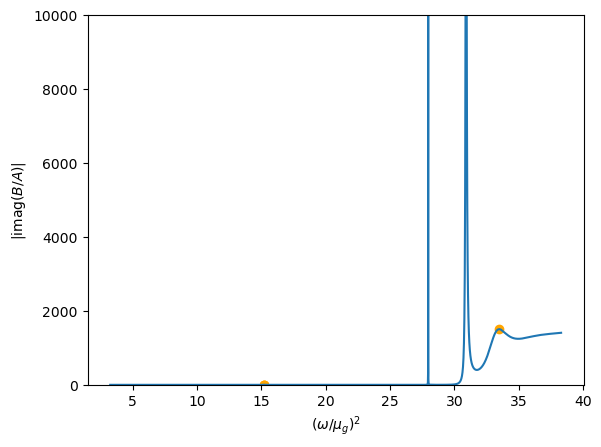

In [1293]:
plt.plot((ws/mug)**2,np.abs(np.imag(BAs)))
plt.xlabel("$(\omega/\mu_g)^2$")
plt.ylabel("|imag($B/A$)|")

plt.scatter((peakws/mug)**2,np.abs(np.imag(peakBAs)),color = 'orange')
#plt.plot(u, psi2[:,0]))

plt.ylim(0,10000)

#plt.xlim(100,400)

print(peakws)
print(peakBAs)

plt.show()

In [1294]:
peakws

array([1512.71244114, 1512.82188052, 1512.95477119, 2051.87334461,
       2157.15402443, 2245.2058196 ])

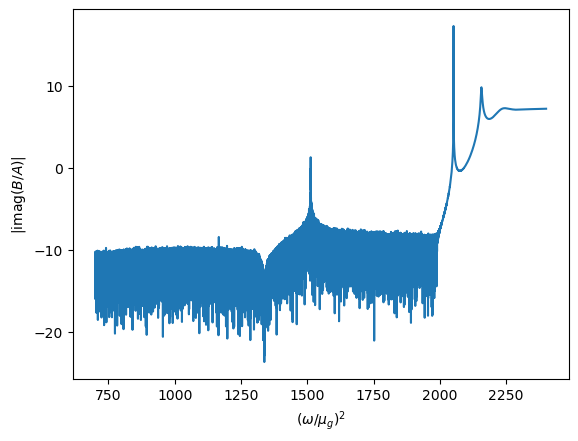

In [1295]:
plt.plot((ws),np.log(np.abs(np.imag(BAs))))
plt.xlabel("$(\omega/\mu_g)^2$")
plt.ylabel("|imag($B/A$)|")

plt.show()

In [1308]:
peaks_log,_ = find_peaks(np.log(np.abs(np.imag(BAs))),prominence = .1,distance = round(100/wresolution))

print(np.sort(ws[peaks_log]))


[ 740.82088729  845.87487125  928.087294   1012.14455194 1166.34463287
 1253.12224102 1354.36148102 1433.63467481 1512.82188052 1600.94402958
 1702.15200118 1841.40579017 1929.42631695 2051.87334461 2157.15402443
 2245.2058196 ]


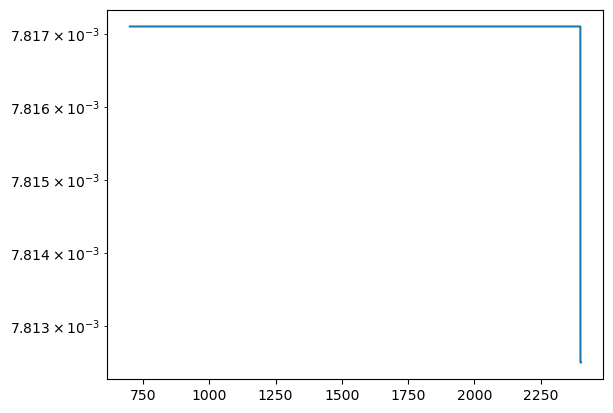

In [1297]:
#plot the derivative of ws 
plt.semilogy(ws[:-1],abs(np.diff(ws)))
plt.show( )

In [1298]:
ws

array([2400.9921875, 2400.984375 , 2400.9765625, ...,  700.0156342,
        700.0078171,  700.       ])

Loading vector data from: data/spectral_data_T18.0_mu0.0_20250408_152309.csv
Loading vector peaks data from: data/peaks_data_T18.0_mu0.0_20250408_152309.csv


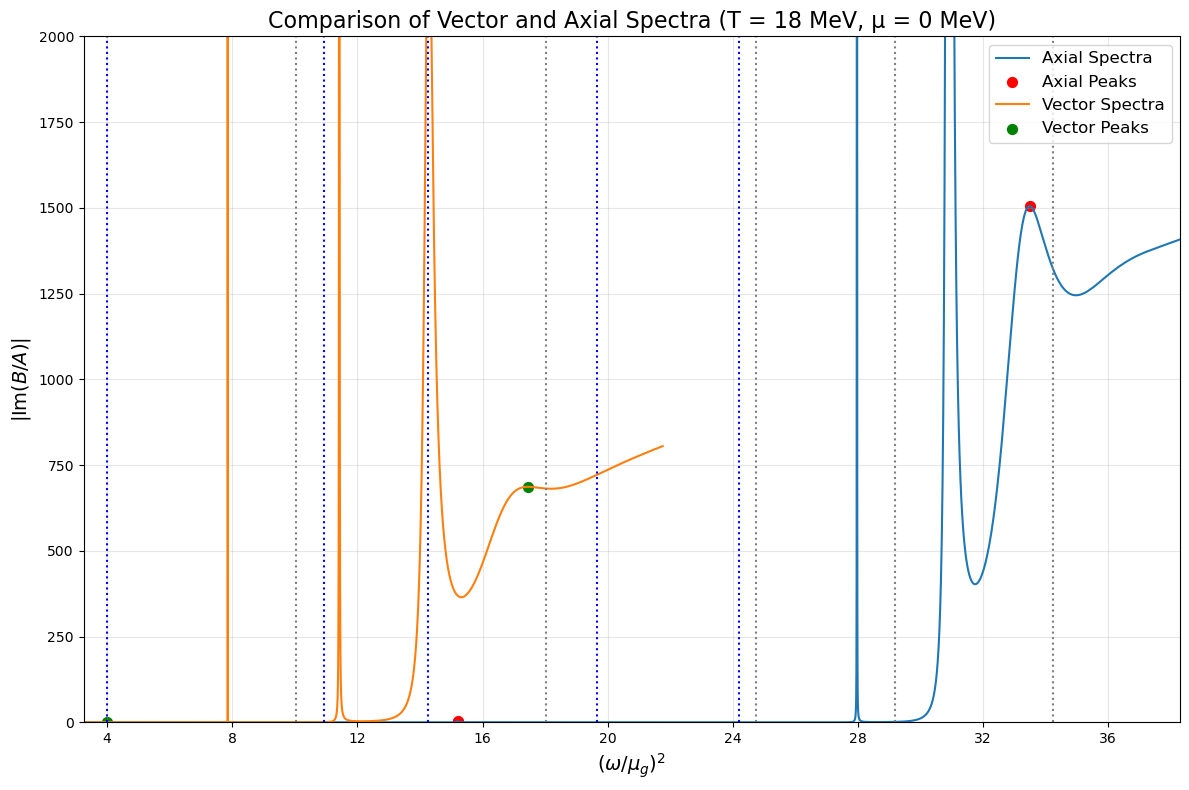

Axial Peaks ω:
[1512.7, 1512.8, 1513.0, 2051.9, 2157.2, 2245.2]
Axial zero temperature experimental values:
[1230 1647 1930 2096 2270]

Vector Peaks ω:
[774.6, 1087.4, 1311.3, 1466.2, 1620.9]
Vector zero temperature experimental values:
[ 775 1282 1465 1720 1909]

Axial Peaks (ω/μg)²:
[15.2, 15.2, 15.21, 27.97, 30.91, 33.48]

Vector Peaks (ω/μg)²:
[3.99, 7.85, 11.42, 14.28, 17.45]

Differences between Axial and Vector Peaks (ω/μg)²:
[11.21, 7.35, 3.78, 13.69, 13.46]


In [1299]:
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd

# Update file patterns to use current T and mu values with one decimal place
vector_file_pattern = f'data/spectral_data_T{T:.1f}_mu{mu:.1f}*.csv'
vector_files = glob.glob(vector_file_pattern)

if vector_files:
    # Sort by modification time (most recent first)
    most_recent_file = max(vector_files, key=os.path.getmtime)
    print(f"Loading vector data from: {most_recent_file}")
    
    # Load the data from CSV
    vector_data = pd.read_csv(most_recent_file)
    
    # Extract the columns (adjust column names if needed)
    vector_ws = vector_data.iloc[:, 0].values
    vector_BAs = vector_data.iloc[:, 1].values + 1j * vector_data.iloc[:, 2].values
    

else:
    print("Vector spectra file not found. Vector spectra will not be plotted.")
    # Don't use dummy data, just create empty variables that won't be plotted
    vector_ws = np.array([])
    vector_BAs = np.array([])
    vector_peakws = np.array([])
    vector_peakBAs = np.array([])
# Look for vector peaks data files
vector_peaks_file_pattern = f'data/peaks_data_T{T:.1f}_mu{mu:.1f}*.csv'
vector_peaks_files = glob.glob(vector_peaks_file_pattern)



# If we found peaks files, use those directly instead of finding peaks again
if vector_peaks_files:
    most_recent_peaks_file = max(vector_peaks_files, key=os.path.getmtime)
    print(f"Loading vector peaks data from: {most_recent_peaks_file}")
    
    # Load the peaks data
    vector_peaks_data = pd.read_csv(most_recent_peaks_file)
    vector_peakws = vector_peaks_data.iloc[:, 0].values
    vector_peakBAs = vector_peaks_data.iloc[:, 1].values + 1j * vector_peaks_data.iloc[:, 2].values
else:
    # Find peaks in vector data (if they're not already in the CSV)
    print("Finding peaks in vector data...")
    from scipy.signal import find_peaks
    vector_peaks_indices, _ = find_peaks(np.abs(np.imag(vector_BAs)), prominence=0.01, distance=10)
    vector_peakws = vector_ws[vector_peaks_indices]
    vector_peakBAs = vector_BAs[vector_peaks_indices]
# Create a figure with good size
plt.figure(figsize=(12, 8))

# Plot axial spectra
axial_line, = plt.plot((ws/mug)**2, np.abs(np.imag(BAs)), label='Axial Spectra')
axial_peaks = plt.scatter((peakws/mug)**2, np.abs(np.imag(peakBAs)), 
                         color='red', s=50, label='Axial Peaks')

# Plot vector spectra 
vector_line, = plt.plot((vector_ws/mug)**2, np.abs(np.imag(vector_BAs)), 
                        label='Vector Spectra')
                    
vector_peaks = plt.scatter((vector_peakws/mug)**2, np.abs(np.imag(vector_peakBAs)), 
                          color='green', s=50, label='Vector Peaks')

zero_T_axial=np.array([1230, 1647,1930,2096,2270])
zero_T_vector=np.array([775,1282,1465,1720,1909])
#put vertical lines at (zero_T_axial/mug)**2
for i in zero_T_axial:
    plt.axvline(x=(i/mug)**2, color='gray', linestyle=':', alpha=1)
#put vertical lines at (zero_T_vector/mug)**2
for i in zero_T_vector:
    plt.axvline(x=(i/mug)**2, color='blue', linestyle=':', alpha=1)


# Add labels and title
plt.xlabel(r"$(\omega/\mu_g)^2$", fontsize=14)
plt.ylabel(r"|Im$(B/A)$|", fontsize=14)
plt.title(f"Comparison of Vector and Axial Spectra (T = {T} MeV, μ = {mu} MeV)", fontsize=16)

# Add a grid for better readability
plt.grid(True, alpha=0.3)
# Set x-axis major gridlines at multiples of 4
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))

# Add legend
plt.legend(fontsize=12)
plt.ylim(0, 2000)
#make the x axis limits from the smallest value of (ws/mug)**2 to the largest value of (ws/mug)**2
plt.xlim(np.min((ws/mug)**2), np.max((ws/mug)**2))
# Show the plot
plt.tight_layout()
plt.show()

# Print the peaks for comparison
print("Axial Peaks ω:")
print([round(w, 1) for w in peakws])
print("Axial zero temperature experimental values:")
print(zero_T_axial)

print("\nVector Peaks ω:")
print([round(w, 1) for w in vector_peakws])
print("Vector zero temperature experimental values:")
print(zero_T_vector)

#print the (w/mug)^2 values for the axial and vector peaks
print("\nAxial Peaks (ω/μg)²:")
print([round((w/mug)**2, 2) for w in peakws])
print("\nVector Peaks (ω/μg)²:")
print([round((w/mug)**2, 2) for w in vector_peakws])

#print the difference between the axial and vector peaks
print("\nDifferences between Axial and Vector Peaks (ω/μg)²:")
print([round((w1/mug)**2 - (w2/mug)**2, 2) for w1, w2 in zip(peakws, vector_peakws)])

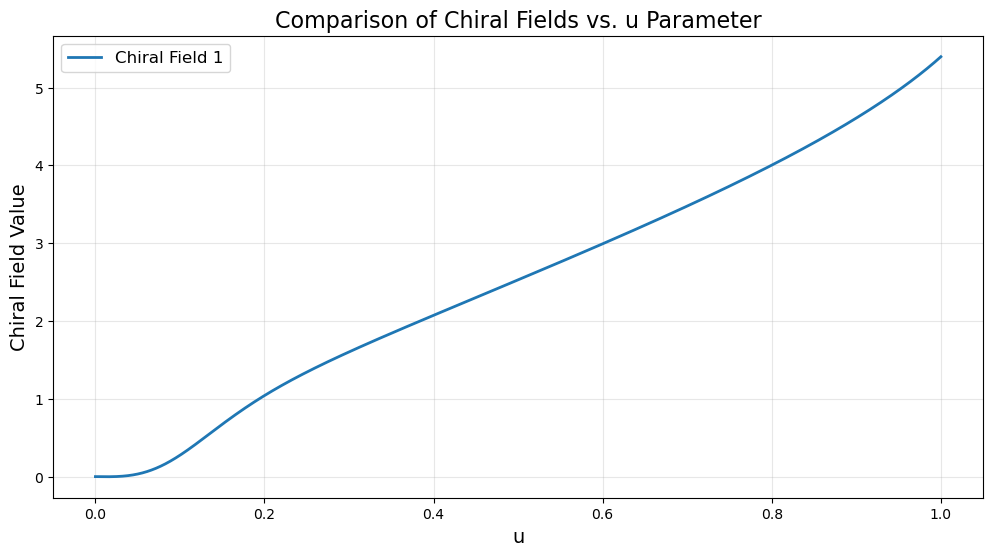

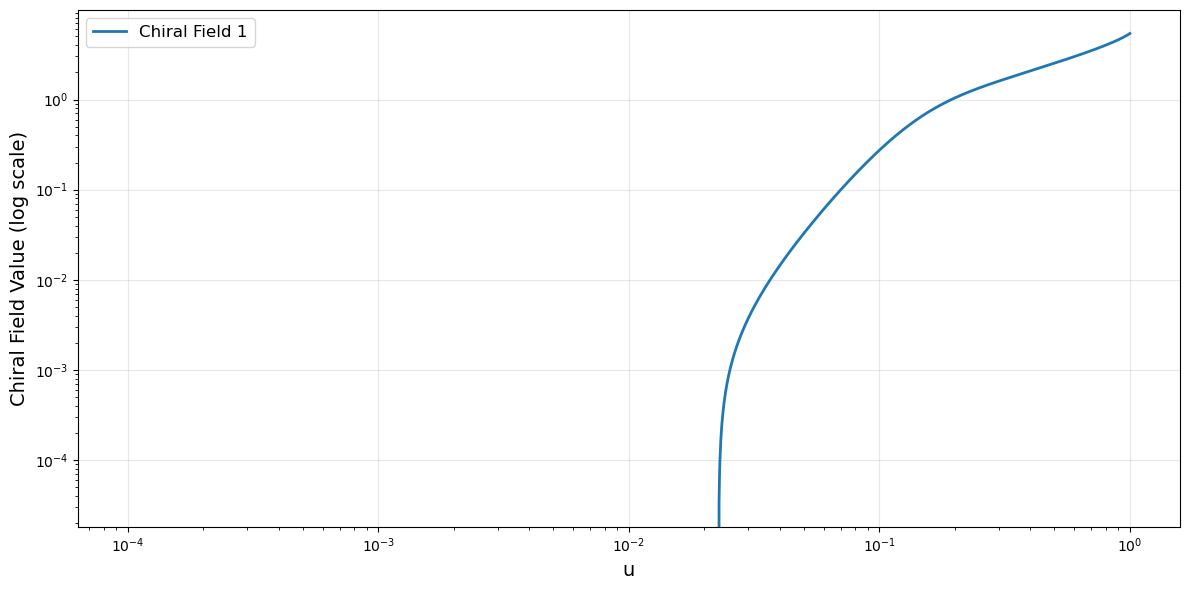

In [1300]:

# Plot all chiral fields for comparison
plt.figure(figsize=(12, 6))

# Plot each chiral field with a different color and label
for i, field in enumerate(chiral_fields):
    plt.plot(u_values, field, linewidth=2, label=f'Chiral Field {i+1}')

# Add labels and grid
plt.xlabel('u', fontsize=14)
plt.ylabel('Chiral Field Value', fontsize=14)
plt.title('Comparison of Chiral Fields vs. u Parameter', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add log scale plot for better visibility of smaller values
plt.figure(figsize=(12, 6))
for i, field in enumerate(chiral_fields):
    plt.loglog(u_values, field, linewidth=2, label=f'Chiral Field {i+1}')

plt.xlabel('u', fontsize=14)
plt.ylabel('Chiral Field Value (log scale)', fontsize=14)
# plt.title('Comparison of Chiral Fields vs. u Parameter (Log Scale)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [1301]:
sigma_values**(1/3)

array([306.25270435])

In [1302]:
result = calculate_sigma_values(.1, mq_tolerance, 44, mu, 7.438, ui, uf) 
sigma_values = result["sigma_values"]     
d0_values = result["d0_values"] 
chiral_fields = result["chiral_fields"] 
chiral_derivatives = result["chiral_derivatives"] 
u_values = result["u_values"]
sigma_values**(1/3)

array([ 54.42202603,  30.96747525, 293.09636856])

In [1303]:
len(chiral_fields[0])

10000

<function matplotlib.pyplot.show(close=None, block=None)>

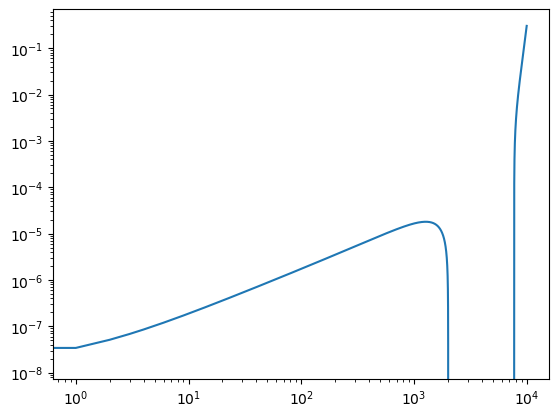

In [1304]:
plt.loglog(chiral_fields[0])
plt.show